In [1]:
def runModel(data, syndata, model, modname, setname, verbose=True):
    import numpy as np
    if verbose: print(f'\nRunning {modname} on {setname}')
    if verbose: print(f'Percent NaN in synthetic data:\n{syndata.isna().sum()/syndata.shape[0]}')
    temp=syndata.shape[0]
    syndata = syndata.dropna()
    if verbose: print(f'Dropped {(temp-syndata.shape[0])/temp:.2f}')
    X = pd.get_dummies(data.iloc[:,:-1])#data.iloc[:,:-1].copy()
    y = data.iloc[:,-1].copy()

    from sklearn.linear_model import LogisticRegression
#     model=LogisticRegression(n_jobs=-1)

    from sklearn.model_selection import cross_val_score
    cv_score = cross_val_score(model, X, y, cv=10, n_jobs=-1).mean()
    
    if verbose: print(f'\nOriginal: {cv_score:.3f}')

    X_syn = pd.get_dummies(syndata.iloc[:,:-1])#syndata.iloc[:,:-1].copy()
    y_syn = syndata.iloc[:,-1].copy()
    
    from sklearn.model_selection import cross_val_score
    cv_score=cross_val_score(model, X_syn, y_syn, cv=10, n_jobs=-1).mean()

    if verbose: print(f'Synthetic: {cv_score:.3f}')

    intersection = list(set(X).intersection(set(X_syn.columns)))
    
    model.fit(X_syn[intersection], y_syn)

    from sklearn import metrics
    
    acc=np.array([metrics.accuracy_score(y, model.predict(X[intersection])) for i in range (10)]).mean()
    if verbose: print(f'Original on synthetic model: {acc:.3f}')
    if verbose: print(f'\nTarget samples\n{y_syn.sample(5)}\n{y.sample(5)}')
    if verbose: print('*'*50)
    
    return acc


In [2]:
def runModelSimple(data, syndata, model, modname, setname, verbose=True):
    import numpy as np
    if verbose: print(f'\nRunning {modname} on {setname}')
    if verbose: print(f'Percent NaN in synthetic data:\n{syndata.isna().sum()/syndata.shape[0]}')
    temp=syndata.shape[0]
    syndata = syndata.dropna()
    dropped=(temp-syndata.shape[0])/temp
    if verbose: print(f'Dropped {dropped:.2f}')
    
    if dropped == 1.0: return 0
    
    X = pd.get_dummies(data.iloc[:,:-1])#data.iloc[:,:-1].copy()
    y = data.iloc[:,-1].copy()

    X_syn = pd.get_dummies(syndata.iloc[:,:-1])#syndata.iloc[:,:-1].copy()
    y_syn = syndata.iloc[:,-1].copy()
    
    intersection = list(set(X).intersection(set(X_syn.columns)))
    
    if verbose: 
        print(f'\nSynthetic-orgininal intersection length is {len(intersection)}, original is {X.shape[1]}')
    
    model.fit(X_syn[intersection], y_syn)

    from sklearn import metrics
    
    acc_dp = metrics.accuracy_score(y, model.predict(X[intersection]))
    if verbose: print(f'Original on synthetic model: {acc_dp:.3f}')
    if verbose: print('*'*50)
    
    return acc_dp

In [3]:
import time
start = time.time()
import pandas as pd
data=pd.read_csv('adult.data', header=None)

data.drop(data[data.eq(' ?').any(1)].index, inplace=True)
data.reset_index(inplace=True, drop=True)

from sklearn.preprocessing import KBinsDiscretizer  
disc = KBinsDiscretizer(n_bins=20, encode='ordinal', strategy='uniform')
arr=disc.fit_transform(data[[2, 10, 11, 12]])
discrete_subset=pd.DataFrame(arr)
data_discrete=data.copy()
data_discrete[[2, 10, 11, 12]]=discrete_subset.astype(int)
data_discrete.iloc[:,-1]=pd.get_dummies(data.iloc[:,-1]).iloc[:,-2]

from sklearn.model_selection import train_test_split
X, y = train_test_split(data_discrete)


print(f'Training\n{X.sample(5)}')
print(f'Testing\n{y.sample(5)}')

res=[]
for i in range(5):    
    print('-'*25,i,'-'*25)

    import jtree_refactored_procedural as jt
    
    try:
        result_table, tree_marginals = jt.JTree(X, verbose=False).synthesize()

        res.append((result_table, tree_marginals))
    except Exception as ex:
        raise
        print(ex)
        print('*'*40,'FAILED','*'*40)
        res.append("FAILED")
    finally:
        pass
print(f'Time : {round(time.time()-start)}')

/home/krudavsk/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


Training
       0                  1   2           3   4                    5   \
27500  33   Self-emp-not-inc   0     HS-grad   9   Married-civ-spouse   
28585  29            Private   3     HS-grad   9   Married-civ-spouse   
20195  44   Self-emp-not-inc   0   Bachelors  13             Divorced   
11593  48            Private   1     HS-grad   9             Divorced   
13727  50            Private   5        11th   7              Widowed   

                       6               7       8        9   10  11  12  \
27500    Transport-moving         Husband   White     Male   0   0  12   
28585   Machine-op-inspct         Husband   White     Male   0   0   9   
20195     Exec-managerial   Not-in-family   White     Male   0   0   7   
11593    Transport-moving   Not-in-family   White     Male   0   0   7   
13727   Machine-op-inspct   Not-in-family   White   Female   0   0   7   

                   13  14  
27500   United-States   1  
28585   United-States   1  
20195   United-States  

/home/krudavsk/syndata/jtree_refactored_procedural.py:252: UserWarning: Domains not provided. Privacy leak!
  warnings.warn("Domains not provided. Privacy leak!", UserWarning)
/home/krudavsk/anaconda3/lib/python3.7/site-packages/pgmpy/models/MarkovModel.py:447: RuntimeWarning: invalid value encountered in long_scalars
  S_by_C = {key: S[key] / C[key] for key in S}



Synthesis execution time: 92.0 s

------------------------- 1 -------------------------


/home/krudavsk/syndata/jtree_refactored_procedural.py:252: UserWarning: Domains not provided. Privacy leak!
  warnings.warn("Domains not provided. Privacy leak!", UserWarning)
/home/krudavsk/anaconda3/lib/python3.7/site-packages/pgmpy/models/MarkovModel.py:447: RuntimeWarning: invalid value encountered in long_scalars
  S_by_C = {key: S[key] / C[key] for key in S}



Synthesis execution time: 77.0 s

------------------------- 2 -------------------------


/home/krudavsk/syndata/jtree_refactored_procedural.py:252: UserWarning: Domains not provided. Privacy leak!
  warnings.warn("Domains not provided. Privacy leak!", UserWarning)
/home/krudavsk/anaconda3/lib/python3.7/site-packages/pgmpy/models/MarkovModel.py:447: RuntimeWarning: invalid value encountered in long_scalars
  S_by_C = {key: S[key] / C[key] for key in S}



Synthesis execution time: 77.0 s

------------------------- 3 -------------------------


/home/krudavsk/syndata/jtree_refactored_procedural.py:252: UserWarning: Domains not provided. Privacy leak!
  warnings.warn("Domains not provided. Privacy leak!", UserWarning)
/home/krudavsk/anaconda3/lib/python3.7/site-packages/pgmpy/models/MarkovModel.py:447: RuntimeWarning: invalid value encountered in long_scalars
  S_by_C = {key: S[key] / C[key] for key in S}



Synthesis execution time: 62.0 s

------------------------- 4 -------------------------


/home/krudavsk/syndata/jtree_refactored_procedural.py:252: UserWarning: Domains not provided. Privacy leak!
  warnings.warn("Domains not provided. Privacy leak!", UserWarning)
/home/krudavsk/anaconda3/lib/python3.7/site-packages/pgmpy/models/MarkovModel.py:447: RuntimeWarning: invalid value encountered in long_scalars
  S_by_C = {key: S[key] / C[key] for key in S}



Synthesis execution time: 101.0 s

Time : 411


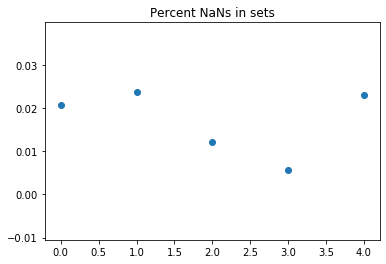


Running MLP on adult
Percent NaN in synthetic data:
0     0.029221
1     0.009283
2     0.001017
3     0.040582
4     0.012953
5     0.024888
6     0.000000
7     0.000000
8     0.000000
9     0.000000
10    0.051412
11    0.051412
12    0.051412
13    0.037929
14    0.000000
dtype: float64
Dropped 0.12

Synthetic-orgininal intersection length is 60, original is 103
Original on synthetic model: 0.822
**************************************************

Running MLP on adult
Percent NaN in synthetic data:
0     0.056231
1     0.030635
2     0.029574
3     0.000000
4     0.000000
5     0.031254
6     0.000000
7     0.031254
8     0.029574
9     0.000000
10    0.029574
11    0.029574
12    0.029574
13    0.029574
14    0.029574
dtype: float64
Dropped 0.06

Synthetic-orgininal intersection length is 89, original is 103
Original on synthetic model: 0.820
**************************************************

Running MLP on adult
Percent NaN in synthetic data:
0     0.009062
1     0.019584
2    

In [4]:
tables=[mat[0] for mat in res if not isinstance(mat[0],str)]
nans = [mat.isna().values.sum()/(mat.shape[0]*mat.shape[1]) for mat in tables]

import numpy as np
import matplotlib.pyplot as plt

plt.scatter(range(len(nans)),nans)
plt.title('Percent NaNs in sets')
plt.show()

print(f'Mean NaN is {np.array(nans).mean()}')

from sklearn.neural_network import MLPClassifier
model = MLPClassifier(max_iter=500)

# from sklearn.model_selection import cross_val_score
# acc_raw = cross_val_score(model, X, y, cv=10).mean()

accs=[runModelSimple(y, table, model, 'MLP', 'adult') for table in tables]
print(f'Mean acc for {len(accs)} runs is {np.array(accs).mean()}')

X = pd.get_dummies(data_discrete.iloc[:,:-1])#data.iloc[:,:-1].copy()
y = data_discrete.iloc[:,-1].copy()

In [5]:
np.array(accs).mean()

0.8204482164169209

In [6]:
%reset -f

    
import numpy as np
import time
start = time.time()
import pandas as pd
data=pd.read_csv('car.data', header=None)

data.drop(data[data.eq(' ?').any(1)].index, inplace=True)
data.reset_index(inplace=True, drop=True)
data_discrete=data

drops=[]
nans=[]

for i in range(2):   
#     IPython.kernel.manager.KernelManager.restart_kernel()
    import jtree_refactored_procedural as jt
    try:
        result_table, tree_marginals = jt.JTree(data_discrete, verbose=False).synthesize()
    #     print(f'Percent NaN in synthetic data:\n{result_table.isna().sum()/result_table.shape[0]}')
        temp=result_table.shape[0]
        numpoints = result_table.shape[0]*result_table.shape[1]
        nans.append(result_table.isna().values.sum())
        result_table = result_table.dropna()
        dropped=(temp-result_table.shape[0])/temp
        print(f'Dropped {dropped:.2f}')
        print(f'NaNs : {nans[-1]/numpoints:.2f}')
        drops.append(dropped)
    finally:
        del jt
        
        

print(f'\navg blind row drop {np.array(drops).mean():.2f}')
print(f'med blind row drop {np.median(drops):.2f}')
print(f'avg nans points {np.array(nans).mean()/numpoints:.2f}')
print(f'med nans points {np.median(nans)/numpoints:.2f}')
print(f'Time : {round(time.time()-start)}')

/home/krudavsk/syndata/jtree_refactored_procedural.py:252: UserWarning: Domains not provided. Privacy leak!
  warnings.warn("Domains not provided. Privacy leak!", UserWarning)
/home/krudavsk/anaconda3/lib/python3.7/site-packages/pgmpy/models/MarkovModel.py:447: RuntimeWarning: invalid value encountered in long_scalars
  S_by_C = {key: S[key] / C[key] for key in S}



Synthesis execution time: 7.0 s

Dropped 0.06
NaNs : 0.05


/home/krudavsk/syndata/jtree_refactored_procedural.py:252: UserWarning: Domains not provided. Privacy leak!
  warnings.warn("Domains not provided. Privacy leak!", UserWarning)
/home/krudavsk/anaconda3/lib/python3.7/site-packages/pgmpy/models/MarkovModel.py:447: RuntimeWarning: invalid value encountered in long_scalars
  S_by_C = {key: S[key] / C[key] for key in S}



Synthesis execution time: 4.0 s

Dropped 0.11
NaNs : 0.05

avg blind row drop 0.09
med blind row drop 0.09
avg nans points 0.05
med nans points 0.05
Time : 12


In [7]:
%run untitled.py

/home/krudavsk/syndata/jtree_refactored_procedural.py:252: UserWarning: Domains not provided. Privacy leak!
  warnings.warn("Domains not provided. Privacy leak!", UserWarning)



Synthesis execution time: 2.0 s

Dropped 0.04
NaNs : 0.01


/home/krudavsk/syndata/jtree_refactored_procedural.py:252: UserWarning: Domains not provided. Privacy leak!
  warnings.warn("Domains not provided. Privacy leak!", UserWarning)
/home/krudavsk/anaconda3/lib/python3.7/site-packages/pgmpy/models/MarkovModel.py:447: RuntimeWarning: invalid value encountered in long_scalars
  S_by_C = {key: S[key] / C[key] for key in S}



Synthesis execution time: 2.0 s

Dropped 0.01
NaNs : 0.00

avg blind row drop 0.03
med blind row drop 0.03
avg nans points 0.01
med nans points 0.01
Time : 5


In [8]:
np.median(drops)

0.025462962962962965

In [11]:
import time
start = time.time()
import pandas as pd


from sklearn import datasets
import numpy as np
from sklearn import preprocessing

var=datasets.fetch_california_housing()
X = np.hstack([var.data, var.target[:,np.newaxis]])
data = pd.DataFrame(X)
print(f'Dataset Size: {data.shape}')

from sklearn.preprocessing import KBinsDiscretizer  
disc = KBinsDiscretizer(strategy='uniform')
data_discrete=pd.DataFrame(disc.fit_transform(data).toarray())

from sklearn.model_selection import train_test_split
X, y = train_test_split(data_discrete)


print(f'Training\n{X.sample(5)}')
print(f'Testing\n{y.sample(5)}')

res=[]
for i in range(5):    
    print('-'*25,i,'-'*25)

    import jtree_refactored_procedural as jt
    
    try:
        result_table, tree_marginals = jt.JTree(X, verbose=False).synthesize()

        res.append((result_table, tree_marginals))
    except Exception as ex:
        raise
        print(ex)
        print('*'*40,'FAILED','*'*40)
        res.append("FAILED")
    finally:
        pass
print(f'Time : {round(time.time()-start)}')

tables=[mat[0] for mat in res if not isinstance(mat[0],str)]
nans = [mat.isna().values.sum()/(mat.shape[0]*mat.shape[1]) for mat in tables]

import numpy as np
import matplotlib.pyplot as plt

plt.scatter(range(len(nans)),nans)
plt.title('Percent NaNs in sets')
plt.show()

from sklearn.neural_network import MLPClassifier
model = MLPClassifier(max_iter=500)

# from sklearn.model_selection import cross_val_score
# acc_raw = cross_val_score(model, X, y, cv=10).mean()

accs=[runModelSimple(y, table, model, 'MLP', 'adult') for table in tables]
print(f'Mean acc for {len(accs)} runs is {np.array(accs).mean()}')

X = pd.get_dummies(data_discrete.iloc[:,:-1])#data.iloc[:,:-1].copy()
y = data_discrete.iloc[:,-1].copy()

Dataset Size: (20640, 9)
Training
        0    1    2    3    4    5    6    7    8    9   ...   35   36   37  \
11427  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
233    0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...  0.0  1.0  0.0   
7003   0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...  0.0  0.0  0.0   
6264   0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...  0.0  0.0  0.0   
19379  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...  0.0  1.0  0.0   

        38   39   40   41   42   43   44  
11427  1.0  0.0  0.0  0.0  1.0  0.0  0.0  
233    0.0  0.0  0.0  0.0  1.0  0.0  0.0  
7003   1.0  0.0  0.0  1.0  0.0  0.0  0.0  
6264   1.0  0.0  0.0  1.0  0.0  0.0  0.0  
19379  0.0  0.0  0.0  1.0  0.0  0.0  0.0  

[5 rows x 45 columns]
Testing
        0    1    2    3    4    5    6    7    8    9   ...   35   36   37  \
1408   1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...  0.0  1.0  0.0   
14046  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.

/home/krudavsk/syndata/jtree_refactored_procedural.py:252: UserWarning: Domains not provided. Privacy leak!
  warnings.warn("Domains not provided. Privacy leak!", UserWarning)
/home/krudavsk/anaconda3/lib/python3.7/site-packages/pgmpy/models/MarkovModel.py:447: RuntimeWarning: invalid value encountered in long_scalars
  S_by_C = {key: S[key] / C[key] for key in S}


ValueError: maximum supported dimension for an ndarray is 32, found 36

In [1]:
import time
start = time.time()
import pandas as pd


from sklearn import datasets
import numpy as np
from sklearn import preprocessing

var=datasets.fetch_covtype()
X = np.hstack([var.data, var.target[:,np.newaxis]])
data = pd.DataFrame(X)
print(f'Dataset Size: {data.shape}')

from sklearn.preprocessing import KBinsDiscretizer  
disc = KBinsDiscretizer(strategy='uniform')
data_discrete=pd.DataFrame(disc.fit_transform(data).toarray())
print(data_discrete.shape)

dims=[len(set(data_discrete[col].values)) for col in data_discrete.columns]

from functools import reduce
product = reduce((lambda x, y: x * y), dims)



# from sklearn.model_selection import train_test_split
# X, y = train_test_split(data_discrete)


# print(f'Training\n{X.sample(5)}')
# print(f'Testing\n{y.sample(5)}')

# res=[]
# for i in range(5):    
#     print('-'*25,i,'-'*25)

#     import jtree_refactored_procedural as jt
    
#     try:
#         result_table, tree_marginals = jt.JTree(X, verbose=False).synthesize()

#         res.append((result_table, tree_marginals))
#     except Exception as ex:
#         raise
#         print(ex)
#         print('*'*40,'FAILED','*'*40)
#         res.append("FAILED")
#     finally:
#         pass

# tables=[mat[0] for mat in res if not isinstance(mat[0],str)]
# nans = [mat.isna().values.sum()/(mat.shape[0]*mat.shape[1]) for mat in tables]

# import numpy as np
# import matplotlib.pyplot as plt

# plt.scatter(range(len(nans)),nans)
# plt.title('Percent NaNs in sets')
# plt.show()

# print(f'Mean NaN is {np.array(nans).mean()}')

# from sklearn.neural_network import MLPClassifier
# model = MLPClassifier(max_iter=500)

# # from sklearn.model_selection import cross_val_score
# # acc_raw = cross_val_score(model, X, y, cv=10).mean()

# accs=[runModelSimple(y, table, model, 'MLP', 'adult') for table in tables]
# print(f'Mean acc for {len(accs)} runs is {np.array(accs).mean()}')

# X = pd.get_dummies(data_discrete.iloc[:,:-1])#data.iloc[:,:-1].copy()
# y = data_discrete.iloc[:,-1].copy()

# print(f'Time : {round(time.time()-start)}')

Dataset Size: (581012, 55)
(581012, 275)


In [2]:
product

11150372599265311570767859136324180752990208

In [8]:
dims=[len(set(data_discrete[col].values)) for col in data_discrete.columns]
np.prod(np.array(dims))

0

In [10]:
import math
int(math.log(product, 2))

143

In [24]:
data_short = data_discrete.iloc[:,:52]
dims=[len(set(data_short[col].values)) for col in data_short.columns]
from functools import reduce
product = reduce((lambda x, y: x * y), dims)
int(math.log(product, 2))
# data_short


51

/home/krudavsk/syndata/jtree_refactored_procedural.py:252: UserWarning: Domains not provided. Privacy leak!
  warnings.warn("Domains not provided. Privacy leak!", UserWarning)


Running on [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19] cores
Changing engines CWD to /home/krudavsk/syndata


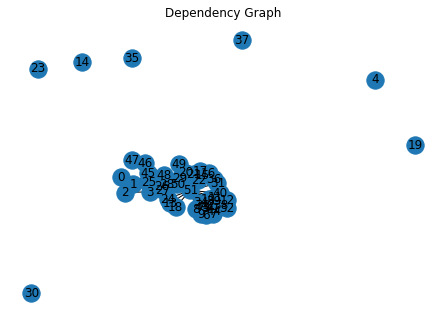

Processing tree [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 20, 21, 22, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 36, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51]


/home/krudavsk/anaconda3/lib/python3.7/site-packages/pgmpy/models/MarkovModel.py:447: RuntimeWarning: invalid value encountered in long_scalars
  S_by_C = {key: S[key] / C[key] for key in S}


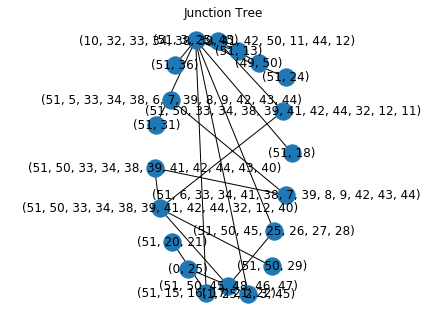

Processing 20 possible mergins...
Merging m = 10 is infeasible
Merging m = 11 is infeasible
Merging m = 12 is infeasible
Merging m = 13 is infeasible
Merging m = 14 is infeasible
Merging m = 15 is infeasible
Merging m = 16 is infeasible
Merging m = 17 is infeasible
Merging m = 18 is infeasible
Merging m = 19 is infeasible
Mergings are [[{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51}], [{0, 10, 11, 12, 15, 16, 17, 20, 21, 22, 25, 32, 33, 34, 36, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 50, 51}, {1, 2, 3, 5, 6, 7, 8, 9, 11, 12, 13, 18, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 38, 39, 40, 41, 42, 43, 44, 45, 49, 50, 51}], [{1, 2, 3, 6, 7, 8, 9, 15, 16, 17, 20, 21, 22, 24, 25, 33, 34, 36, 38, 39, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51}, {10, 11, 12, 13, 18, 25, 26, 27, 28, 29, 32, 33, 34, 38, 39, 41, 42, 44, 45, 50, 51}, {0, 3, 5, 6, 7, 8

KeyboardInterrupt: 

In [25]:
import jtree_refactored_procedural as jt
result_table, tree_marginals = jt.JTree(data_short, verbose=True).synthesize()